In [16]:
#import packages and functions
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import geopandas as gpd
import os
import fiona
import shapely
from shapely import wkt

In [17]:
from general_functions import *

%load_ext autoreload
%autoreload 2
pd.set_option('display.max_columns', None)


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Amstel, Gooi en Vecht

In [18]:
#define relative paths
waterschap = 'AVG'
path_AVG = '..\..\Data_preprocessed\Waterschappen\AmstelGooienVecht'
output_gpkg_path = "../../Data_postprocessed/Waterschappen/AmstelGooienVecht"
DM_path = '..\..\Data_overig\DM_Netwerk\DM_Netwerk.shp'


In [19]:
#AVG has delivered all data in CSV format. Load it in manually with some data mutations
AVG = {}
variables = ['stuw', 'gemaal', 'afsluitmiddel', 'duikersifonhevel', 'hydroobject']#, 'peilgebiedpraktijk', 'peilafwijkinggebied']
for variable in variables:
    path_variable = os.path.join(path_AVG, variable + '.csv')
    df_var = pd.read_csv(path_variable, delimiter=';')
    geom_col = df_var.keys()[-1] #retrieve the column name
    
    if not 'geometrie' in geom_col:
        raise ValueError('No "geometry" string found in the last column of the dataframe. Check for existence') 
    
    df_var['geometry'] = df_var[geom_col].apply(lambda x: wkt.loads(x.split(';')[-1])) 
    AVG[variable] = df_var
    
#there is one last gpkg which contains the streefpeilen (and peilgebieden)
AVG['peilgebied'] = gpd.read_file(os.path.join(path_AVG, 'vigerende_peilgebieden.gpkg'))

Number of missing streefpeilen =  5


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


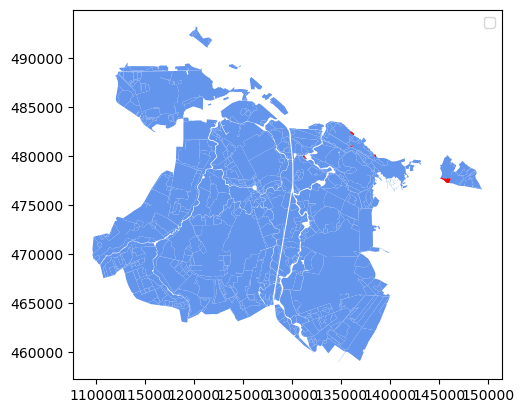

In [20]:
AVG['peilgebied']['streefpeil'] = np.nan
AVG['peilgebied']['streefpeil'] = AVG['peilgebied']['streefpeil'].fillna(value=AVG['peilgebied']['GPGZMRPL'])
AVG['peilgebied']['streefpeil'] = AVG['peilgebied']['streefpeil'].fillna(value=AVG['peilgebied']['IWS_GPGVASTP'])
AVG['peilgebied']['streefpeil'] = AVG['peilgebied']['streefpeil'].fillna(value=AVG['peilgebied']['IWS_GPGONDP'])


print('Number of missing streefpeilen = ', len(AVG['peilgebied']['streefpeil'].loc[AVG['peilgebied']['streefpeil'].isna()]))

fig, ax = plt.subplots()
AVG['peilgebied'].geometry.plot(ax=ax, color='cornflowerblue')
AVG['peilgebied'].loc[AVG['peilgebied']['streefpeil'].isna()].geometry.plot(ax=ax, color='red')
ax.legend()

# Nalevering

In [21]:
#overwrite previous data
AVG['stuw'] = gpd.read_file(r"D:\Users\Bruijns\Documents\PR4750_20\Data_preprocessed\Waterschappen\AmstelGooienVecht\data dump 6 maart LHM AGV\Stuw.shp")
AVG['stuw'] = AVG['stuw'].loc[AVG['stuw'].LHM == 'LHM']

AVG['gemaal'] = gpd.read_file(r"D:\Users\Bruijns\Documents\PR4750_20\Data_preprocessed\Waterschappen\AmstelGooienVecht\data dump 6 maart LHM AGV\Gemaal.shp")
AVG['gemaal'] = AVG['gemaal'].loc[AVG['gemaal'].LHM == 'LHM']

AVG['duikersifonhevel'] = gpd.read_file(r"D:\Users\Bruijns\Documents\PR4750_20\Data_preprocessed\Waterschappen\AmstelGooienVecht\data dump 6 maart LHM AGV\Duikersifonhevel.shp")
AVG['hydroobject'] = gpd.read_file(r"D:\Users\Bruijns\Documents\PR4750_20\Data_preprocessed\Waterschappen\AmstelGooienVecht\data dump 6 maart LHM AGV\LHM_hydrovakken.shp")

AVG['peilgebied'] = gpd.read_file(r"D:\Users\Bruijns\Documents\PR4750_20\Data_preprocessed\Waterschappen\AmstelGooienVecht\data dump 6 maart LHM AGV\LHM_gebieden.shp")


In [22]:
AVG['peilgebied'].loc[AVG['peilgebied'].zomer == 0, 'zomer'] = np.nan
AVG['peilgebied'].loc[AVG['peilgebied'].winter == 0, 'winter'] = np.nan
AVG['peilgebied'].loc[AVG['peilgebied'].vast == 0, 'vast'] = np.nan

In [23]:
AVG['peilgebied']['streefpeil'] = AVG['peilgebied'][['vast', 'zomer']].min(axis=1, skipna=True)


In [24]:
#determine aanvoer en afvoer gemalen
AVG['gemaal']['func_aanvoer'], AVG['gemaal']['func_afvoer'], AVG['gemaal']['func_circulatie']  = False, False, False #default is False
AVG['gemaal']['functiegemaal'] = AVG['gemaal']['naam'].astype(str) # aan AGV gevraagd of alle opmaling informatie in de kolom 'naam' verwerkt is. Antwoord: ja

AVG['gemaal'].loc[AVG['gemaal']['functiegemaal'] == 'onbekend', 'functiegemaal'] = np.nan #replace onbekend with nan, will be filled up later see one line below

AVG['gemaal'].loc[AVG['gemaal'].functiegemaal.str.contains('fvoer|nderbemaling|f-|oodpomp'), 'func_afvoer'] = True
AVG['gemaal'].loc[AVG['gemaal'].functiegemaal.str.contains('anvoergemaal|pmaling|an-|p-|pvoer'), 'func_aanvoer'] = True
AVG['gemaal'].loc[AVG['gemaal'].functiegemaal.str.contains('irculatie'), 'func_circulatie'] = True
AVG['gemaal'].loc[(AVG['gemaal'].func_afvoer == False) &
                       (AVG['gemaal'].func_aanvoer == False) &
                       (AVG['gemaal'].func_circulatie == False), 'func_afvoer'] = True #set to afvoergemaal is there the function is unknown

In [25]:
#stuw
AVG['stuw'] = AVG['stuw'][['code', 'geometry']]
AVG['stuw'].loc[:, 'nen3610id'] = 'dummy_nen3610id_stuw_' + AVG['stuw'].index.astype(str)
AVG['stuw']['globalid'] = 'dummy_globalid_stuw_' + AVG['stuw'].index.astype(str)
AVG['stuw'] = gpd.GeoDataFrame(AVG['stuw']).to_crs('epsg:28992')

#gemaal
AVG['gemaal'] = AVG['gemaal'][['code', 'func_afvoer', 'func_aanvoer', 'func_circulatie', 'geometry']]
AVG['gemaal'].loc[:, 'nen3610id'] = 'dummy_nen3610id_gemaal_' + AVG['gemaal'].index.astype(str)
AVG['gemaal']['globalid'] = 'dummy_globalid_gemaal_' + AVG['gemaal'].index.astype(str)
AVG['gemaal'] = gpd.GeoDataFrame(AVG['gemaal']).to_crs('epsg:28992')

#afsluitmiddel
AVG['afsluitmiddel'] = AVG['afsluitmiddel'][['code', 'geometry']]
AVG['afsluitmiddel'].loc[:, 'nen3610id'] = 'dummy_nen3610id_afsluitmiddel_' + AVG['afsluitmiddel'].index.astype(str)
AVG['afsluitmiddel']['globalid'] = 'dummy_globalid_afsluitmiddel_' + AVG['afsluitmiddel'].index.astype(str)
AVG['afsluitmiddel'] = gpd.GeoDataFrame(AVG['afsluitmiddel']).set_crs('epsg:28992')

#duikersifonhevel
AVG['duikersifonhevel'] = AVG['duikersifonhevel'][['code', 'geometry']]
AVG['duikersifonhevel'].loc[:, 'nen3610id'] = 'dummy_nen3610id_duikersifonhevel_' + AVG['duikersifonhevel'].index.astype(str)
AVG['duikersifonhevel']['globalid'] = 'dummy_globalid_duikersifonhevel_' + AVG['duikersifonhevel'].index.astype(str)
AVG['duikersifonhevel'] = gpd.GeoDataFrame(AVG['duikersifonhevel']).to_crs('epsg:28992')

#hydroobject
AVG['hydroobject'] = AVG['hydroobject'][['geometry']]
AVG['hydroobject']['code'] = 'dummy_code_hydroobject_' + AVG['hydroobject'].index.astype(str)
AVG['hydroobject']['nen3610id'] = 'dummy_nen3610id_hydroobject_' + AVG['hydroobject'].index.astype(str)
AVG['hydroobject']['globalid'] = 'dummy_globalid_hydroobject_' + AVG['hydroobject'].index.astype(str)
AVG['hydroobject'] = gpd.GeoDataFrame(AVG['hydroobject']).set_crs('epsg:28992')

#streefpeil
AVG['streefpeil'] = pd.DataFrame()
AVG['streefpeil']['waterhoogte'] = AVG['peilgebied']['streefpeil']
AVG['streefpeil']['globalid'] = 'dummy_globalid_streefpeil_' + AVG['streefpeil'].index.astype(str)
AVG['streefpeil']['geometry'] = np.nan
AVG['streefpeil'] = gpd.GeoDataFrame(AVG['streefpeil']).set_crs('epsg:28992')

#peilgebied
AVG['peilgebied']['code'] = AVG['peilgebied']['GAFNAAM']
AVG['peilgebied']['geometry'] = AVG['peilgebied']['geometry']
AVG['peilgebied']['nen3610id'] = 'dummy_nen3610id_peilgebied_' + AVG['peilgebied'].index.astype(str)
AVG['peilgebied']['globalid'] = 'dummy_globalid_peilgebied_' + AVG['peilgebied'].index.astype(str)


AVG['peilgebied'] = AVG['peilgebied'][['code', 'nen3610id', 'globalid', 'geometry']]
AVG['peilgebied'] = gpd.GeoDataFrame(AVG['peilgebied']).to_crs('epsg:28992')


In [32]:
#add duikersifonhevels to the hydroobjecten    
AVG['hydroobject'] = pd.concat([AVG['hydroobject'], AVG['duikersifonhevel']])
AVG['hydroobject'] = AVG['hydroobject'].drop_duplicates(subset='globalid') #in case it is run multiple times
AVG['hydroobject'] = gpd.GeoDataFrame(AVG['hydroobject']).set_crs('epsg:28992')


# Control, store

In [33]:
show_layers_and_columns(waterschap = AVG)

stuw
['code' 'geometry' 'nen3610id' 'globalid']
type =  <class 'geopandas.geodataframe.GeoDataFrame'>
crs =  epsg:28992

gemaal
['code' 'func_afvoer' 'func_aanvoer' 'func_circulatie' 'geometry'
 'nen3610id' 'globalid']
type =  <class 'geopandas.geodataframe.GeoDataFrame'>
crs =  epsg:28992

afsluitmiddel
['code' 'geometry' 'nen3610id' 'globalid']
type =  <class 'geopandas.geodataframe.GeoDataFrame'>
crs =  epsg:28992

duikersifonhevel
['code' 'geometry' 'nen3610id' 'globalid']
type =  <class 'geopandas.geodataframe.GeoDataFrame'>
crs =  epsg:28992

hydroobject
['geometry' 'code' 'nen3610id' 'globalid']
type =  <class 'geopandas.geodataframe.GeoDataFrame'>
crs =  epsg:28992

peilgebied
['code' 'nen3610id' 'globalid' 'geometry']
type =  <class 'geopandas.geodataframe.GeoDataFrame'>
crs =  epsg:28992

streefpeil
['waterhoogte' 'globalid' 'geometry']
type =  <class 'geopandas.geodataframe.GeoDataFrame'>
crs =  epsg:28992



In [34]:
# Check if the directory exists
if not os.path.exists(output_gpkg_path):
    # If it doesn't exist, create it
    os.makedirs(output_gpkg_path)
    
store_data(waterschap = AVG, 
           output_gpkg_path = output_gpkg_path + '/AGV')
